In [1]:
from pathlib import Path
from typing import Tuple, Dict

import pandas as pd

In [2]:
from ethicml.algorithms.inprocess import GPyT, GPyTDemPar, GPyTEqOdds, LR, SVM, Agarwal, Kamiran, Kamishima, LRCV, ZafarEqOpp
from ethicml.evaluators import evaluate_models, CrossValidator, run_metrics, evaluate_models_parallel
from ethicml.data import Compas, Adult, load_data
from ethicml.metrics import Accuracy, ProbPos, TPR, TNR, AbsCV
from ethicml.preprocessing import TrainTestSplit, train_test_split
from ethicml.visualisation.plot import plot_results, single_plot
from ethicml.utility import DataTuple

In [3]:
# from lr_torch_api import LrTorch, EOFlags
from lr_torch import LrTorch, EOFlags

In [4]:
data = [
    Compas("Race"),
    Compas("Sex"),
#     Adult("Race"),
#     Adult("Sex"),
]

In [5]:
class TrainTrainSplit(TrainTestSplit):
    """Standard train test split"""
    def __call__(
        self, data: DataTuple, split_id: int
    ) -> Tuple[DataTuple, DataTuple, Dict[str, float]]:
        random_seed = self._get_seed(split_id)
        split_info: Dict[str, float] = {'seed': random_seed}
        train, _ = train_test_split(data, self.train_percentage, random_seed)
        return train, train, split_info

In [9]:
use_s = False
results = evaluate_models(
    datasets=data,
    inprocess_models=[
#         LrTorch(use_s=use_s),
        SVM(),

#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=.9, p_ybary1_s1=.9, p_ybary0_s0=.6, p_ybary0_s1=.6), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=.9, p_ybary1_s1=.9, p_ybary0_s0=.65, p_ybary0_s1=.65), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.65, p_ybary0_s1=.65), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.6, p_ybary0_s1=.6), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.7, p_ybary0_s1=.7), use_s=use_s),
    ],
    metrics=[Accuracy(), TPR(), TNR()],
    per_sens_metrics=[TPR(), TNR()],
    repeats=2,
    topic="test_on_train",
    splitter=TrainTrainSplit(),
#     max_parallel=5,
)

100%|██████████| 4/4 [00:59<00:00, 14.75s/it, model=SVM, dataset=Compas Sex, transform=no_transform, repeat=1] 


In [10]:
results.data

Accuracy  \
dataset     transform    model                                              split_id             
Compas Race no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0         0.684776   
                                                                            1         0.683560   
                         SVM                                                0         0.686398   
                                                                            1         0.687614   
Compas Sex  no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0         0.679505   
                                                                            1         0.671194   
                         SVM                                                0         0.684168   
                                                                            1         0.685587   

                                                                                           TNR  \
dataset     transform    model                                              split_id             
Compas Race no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0         0.600150   
                                                                            1         0.612222   
                         SVM                                                0         0.785474   
                                                                            1         0.799259   
Compas Sex  no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0         0.593785   
                                                                            1         0.565926   
                         SVM                                                0         0.781355   
                                                                            1         0.794815   

                                                                                      TNR_race_0  \
dataset     transform    model                                              split_id               
Compas Race no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0           0.554420   
                                                                            1           0.563287   
                         SVM                                                0           0.740229   
                                                                            1           0.757049   
Compas Sex  no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0                NaN   
                                                                            1                NaN   
                         SVM                                                0                NaN   
                                                                            1                NaN   

                                                                                      TNR_race_0-race_1  \
dataset     transform    model                                              split_id                      
Compas Race no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0                  0.121176   
                                                                            1                  0.127903   
                         SVM                                                0                  0.119891   
                                                                            1                  0.110328   
Compas Sex  no_transform LR (torch), wd: 0.1, RAdam, TPR_t: 0.9, TNR_t: 0.6 0                       NaN   
                                                                            1                       NaN   
                         SVM                                                0                       NaN   
                                                                            1                       NaN   

                                                    

In [11]:
def _mapper(idx):
    dataset, transform, model, repeat = idx
    if model.startswith("LR"):
        new_name = model.replace("LR (torch), wd: 0.1, RAdam,", "FairLR,")
        new_name = new_name.replace("LR (torch), wd: 0.1, RAdam", "LR,")
        new_name = new_name.replace("TPR_t", "$TPR_t$")
        new_name = new_name.replace("TNR_t", "$TNR_t$")
        return dataset, transform, new_name, repeat
    return idx
results_mapped = results.copy()
results_mapped.index = results_mapped.index.map(_mapper)

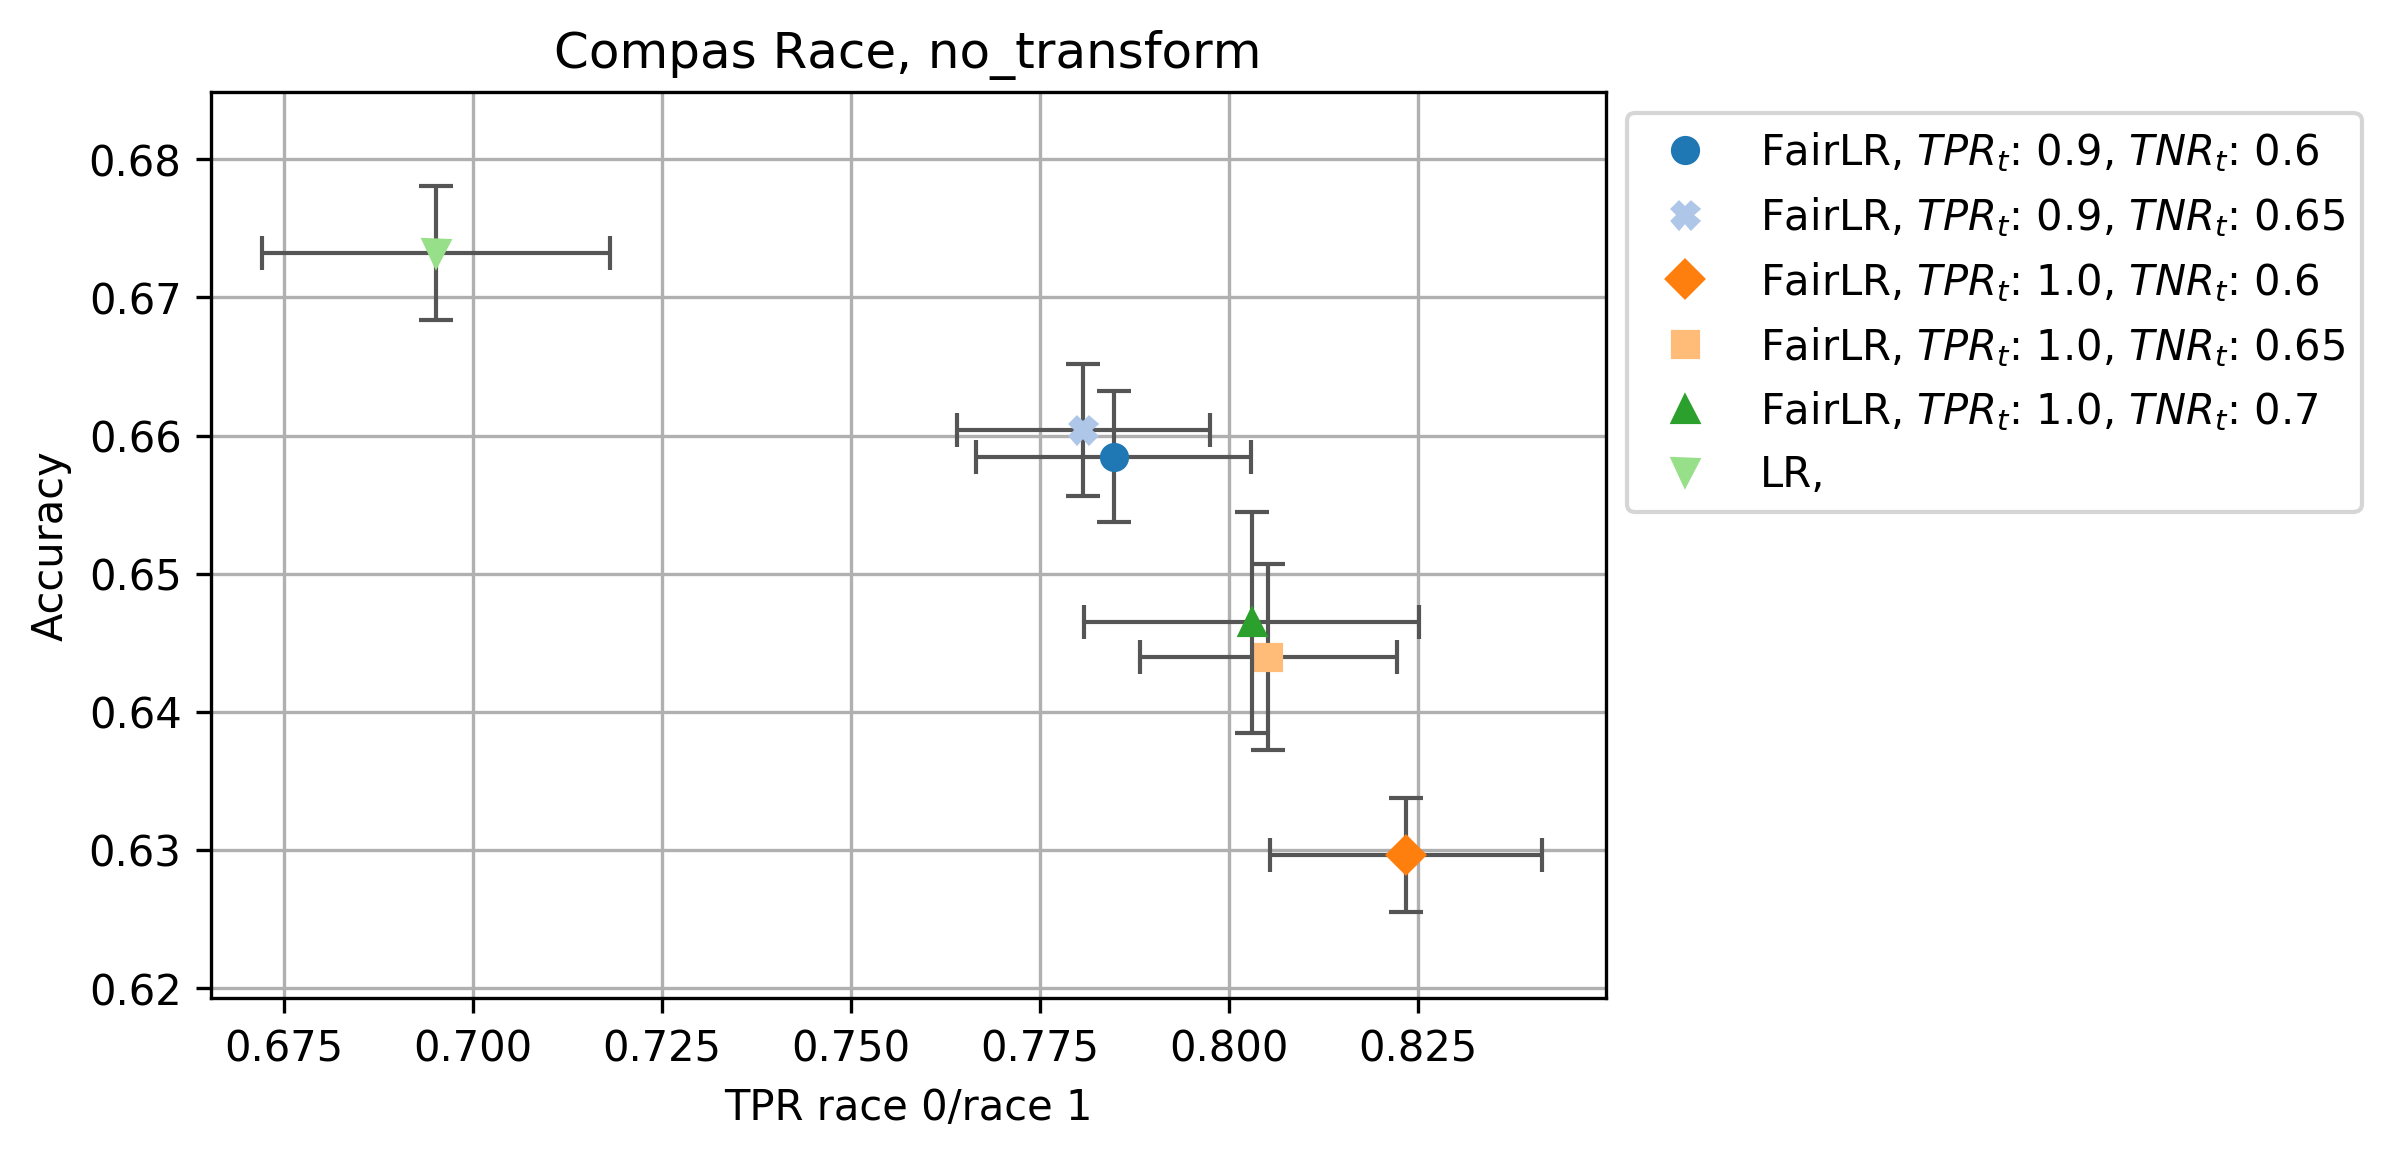

In [12]:
# results = pd.read_csv("results/Compas Race_no_transform.csv").set_index(["dataset", "transform", "model", "repeat"])

plot_mean_std_box(results_mapped, "Accuracy", "TPR_race_0/race_1", save=False, use_cross=True)[0][0]

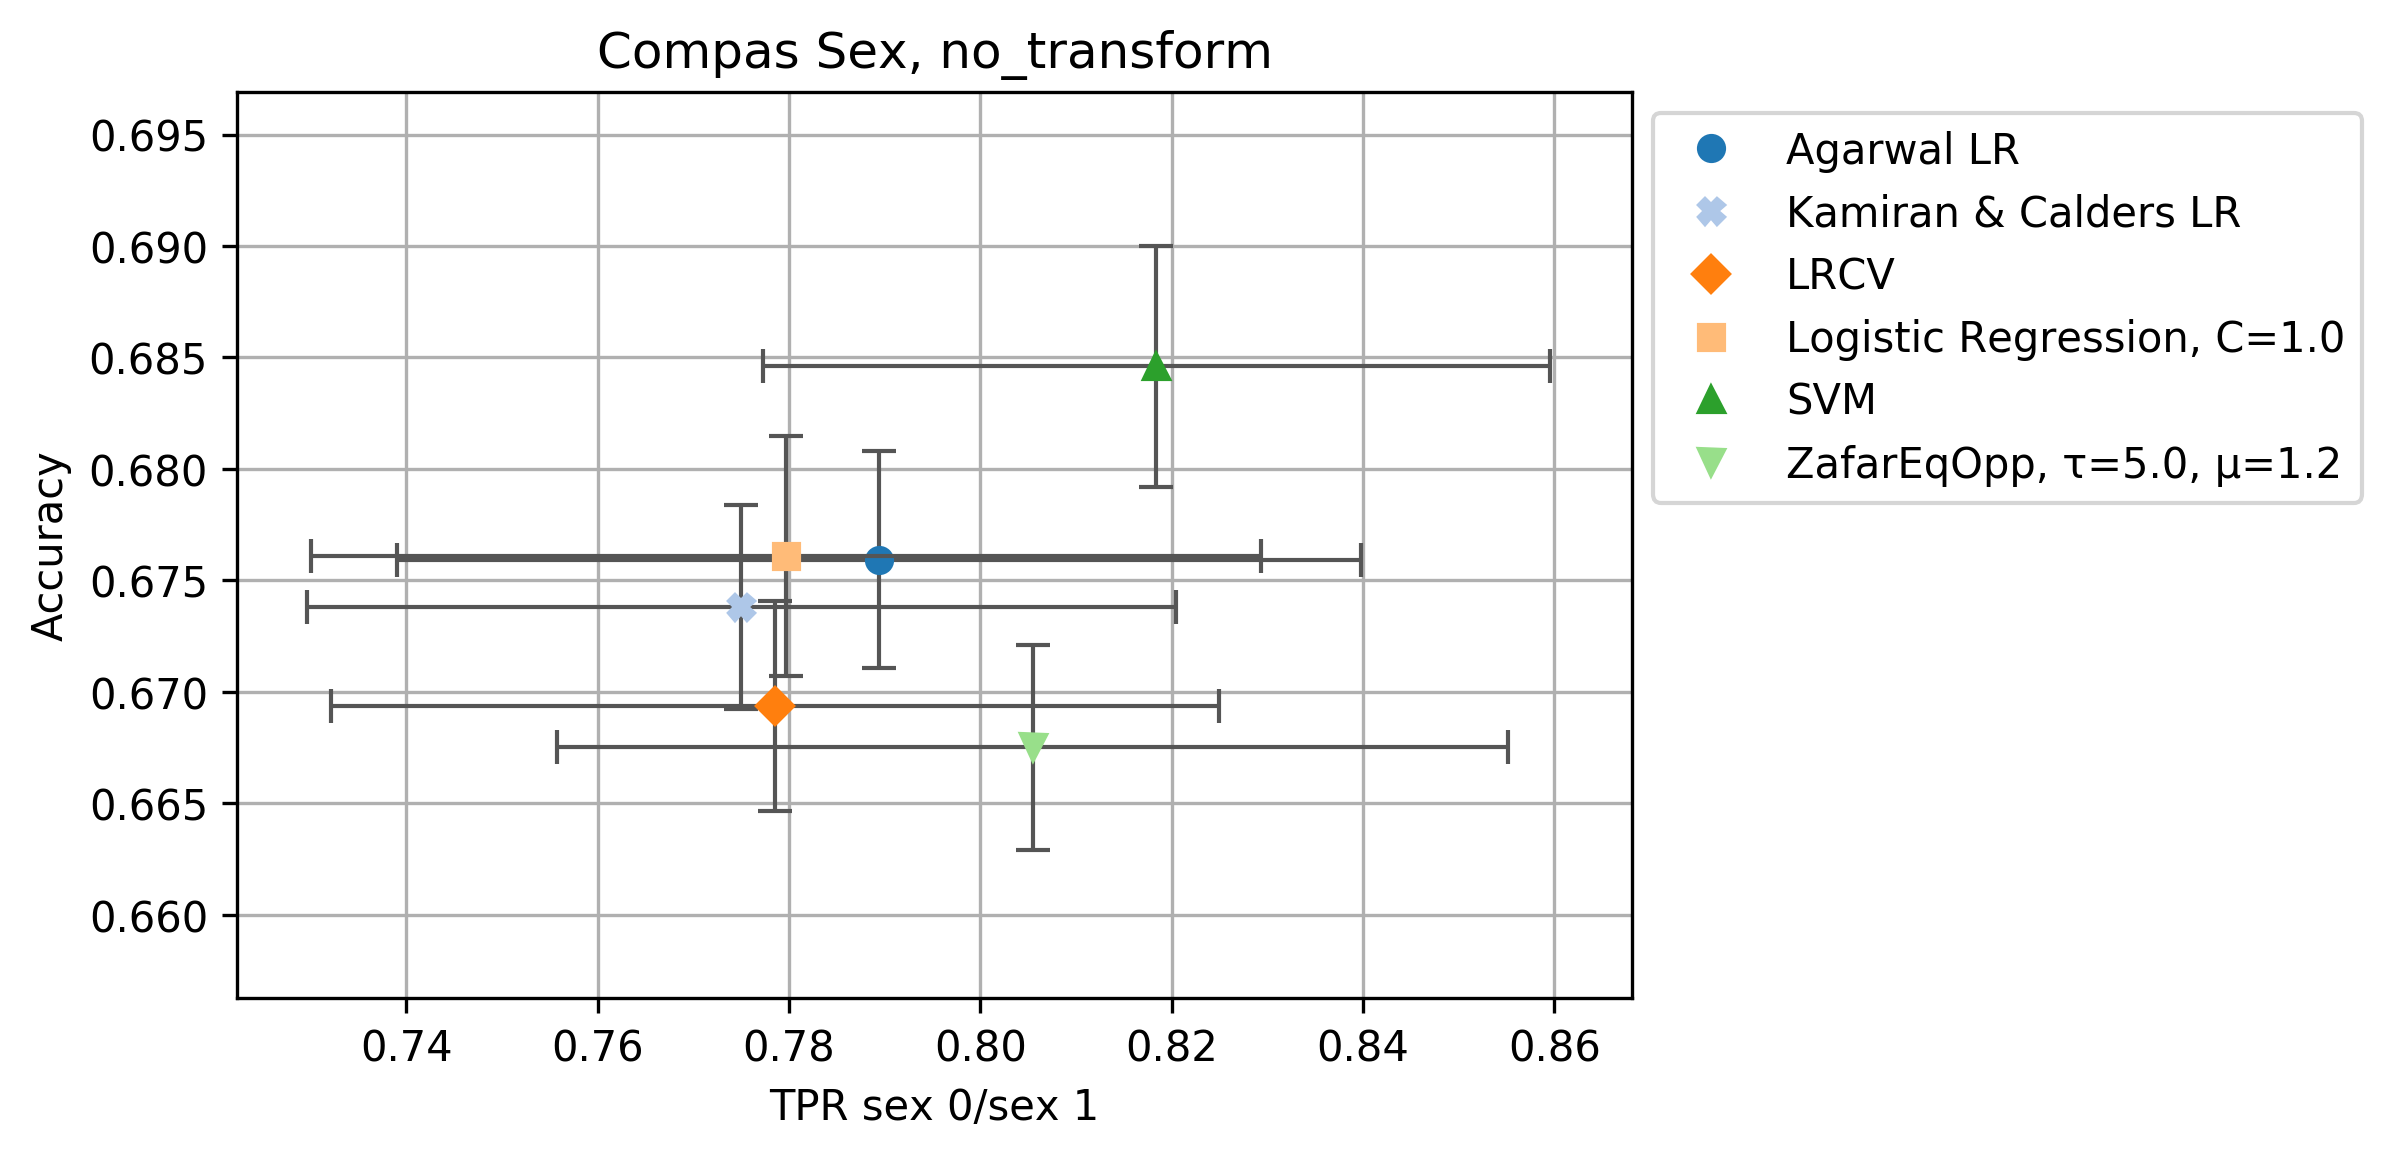

In [11]:
plot_mean_std_box(results, "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]

In [ ]:
plot_mean_std_box(results.query('~model.str.contains("True")'), "Accuracy", "TPR_race_0/race_1", save=False, use_cross=True)[0][0]

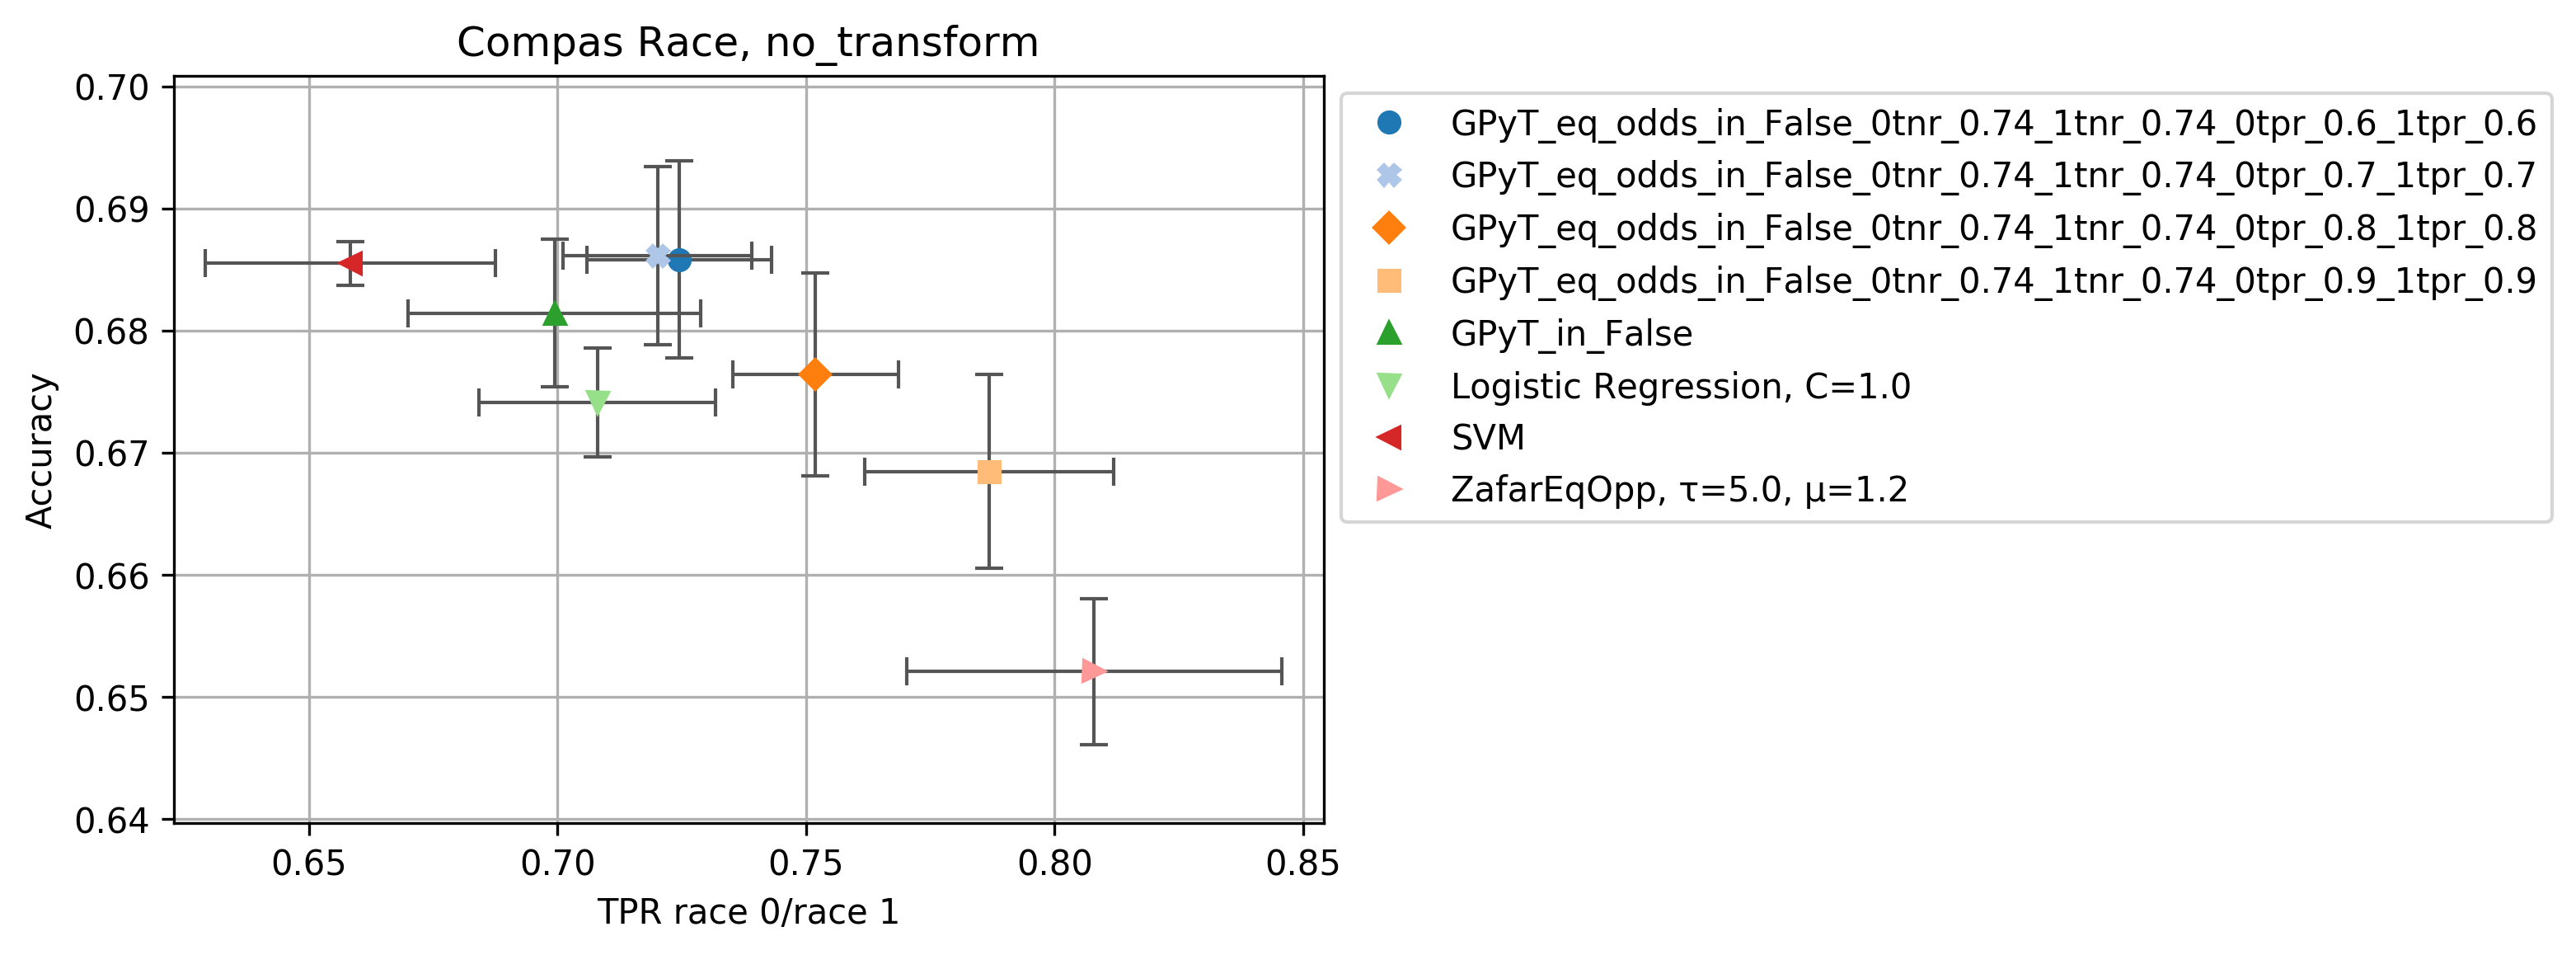

In [56]:
plot_mean_std_box(results.query('~model.str.contains("True")'), "Accuracy", "TPR_sex_0/sex_1", save=False, use_cross=True)[0][0]

In [6]:
use_s = False
test_results = evaluate_models_parallel(
    datasets=data,
    inprocess_models=[
        LrTorch(use_s=use_s),

#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=.9, p_ybary1_s1=.9, p_ybary0_s0=.6, p_ybary0_s1=.6), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=.9, p_ybary1_s1=.9, p_ybary0_s0=.65, p_ybary0_s1=.65), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.65, p_ybary0_s1=.65), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.6, p_ybary0_s1=.6), use_s=use_s),
#         LrTorch(fair=True, debiasing_args=EOFlags(p_ybary1_s0=1., p_ybary1_s1=1., p_ybary0_s0=.7, p_ybary0_s1=.7), use_s=use_s),
    ],
    metrics=[Accuracy(), TPR(), TNR()],
    per_sens_metrics=[TPR(), TNR()],
    repeats=1,
    topic="tests",
    proportional_splits=True,
    max_parallel=2,
)

100%|██████████| 2/2 [00:31<00:00, 15.83s/it, model=LR (torch), wd: 0.1, RAdam, dataset=Compas Sex - Train, worker_id=1]
